# **Github and Google Colab Implementation of Character Recognition TMINST**

## **Importing All necessary libraries**

In [1]:
#import pytorch
import torch

# torch functionalities used for building our CNN Model
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data as data_utils

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## **How to train your neural net faster?**

We saw that the computationally intensive part of neural network is made up of multiple matrix multiplications. So how can we make it faster?

Since we will be building a CNN model, a GPU is required to speed up the training process. Before starting with the implementation, we verify the presence of an active GPU and set the device accordingly.



In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [5]:
import pandas as pd
#Reading data into pandas dataframe.
#data_path = "https://raw.githubusercontent.com/Payal2000/TMINST/main/TMNIST_Data.csv"
data_path = "https://raw.githubusercontent.com/Payal2000/TMINST/main/TMNIST_Data.csv"
data = pd.read_csv(data_path)


## **Performing EDA**

In [6]:
#A view of dataset.
data.head()

,names,labels,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,GrandHotel-Regular,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,EncodeSansCondensed-Medium,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Varela-Regular,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ArefRuqaa-Bold,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,KulimPark-Regular,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Determining Shape and Number of Sample in the Dataset
print(f"The Shape of the Dataframe is: {data.shape}") #Number of Samples, Number of Pixels(Features)
print(f"Number of Samples: {data.shape[0]}")

The Shape of the Dataframe is: (29900, 786)
Number of Samples: 29900


In [8]:
# Number of unique character in the Dataframe
print(f"Number of unique character present in the Dataset: {len(data.labels.unique())}") #Number of Classes

Number of unique character present in the Dataset: 10


In [9]:
# Label distribution
data.labels.value_counts()


2    2990
8    2990
4    2990
3    2990
1    2990
6    2990
5    2990
9    2990
7    2990
0    2990
Name: labels, dtype: int64

We observe that the labels are equally distributed with 2990 instances of each class. Hence, our dataset is balanced.

Now, let us reshape and modify our data so that it can be used as an input for our model. We normalise the data and reshape it into a 4 dimensional array such that it represents images stacked on to each other. We also reshape our labels into a 1 dimensional array.

In [10]:
#Dropping redundant coloums like names and labels from the training frames and keeping only pixel values
X = data.drop(columns = {'names', 'labels'})/255
X = X.values.reshape(X.shape[0], 1, 28, 28)
y = data[['labels']].values.reshape((-1,))

Before proceeding, we split our data into training and testing sets using an 80:20 proportion.

In [11]:
#split data into training and testing sets using the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

We now convert them to numpy arrays so that they can be further worked with.

In [12]:
# Convert X_train, X_test, y_train, and y_test to PyTorch tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

Before proceeding, we split our data into training and testing sets using an 80:20 proportion.

In [13]:
#printing shape
print(X_train.shape, y_train.shape)

torch.Size([23920, 1, 28, 28]) torch.Size([23920])


We verify our steps by checking the shape of our newly created torch tensors.

Now, let us visualise a sample image from our processed data.

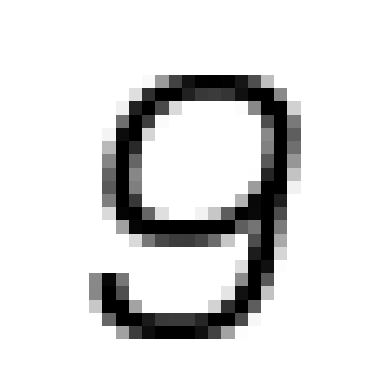

In [14]:
def visualize_image(data):
    # Display the image using matplotlib's imshow() function
    plt.imshow(data[0], cmap='gray_r')
    # Turn off the axis display in the plot
    plt.axis("off")
    # Show the plot with the displayed image
    plt.show()

# Call the visualize_image() function with the first image in X_train dataset
visualize_image(X_train[0])

## **Create a CNN Model**
Create Data Loader Dataloaders are utilized to feed our input data to our model for training, based on different parameters such as the batch size, if they should be suffled while being fed, and so on.

Here, we define our tensordatasets for the dataloader and then input our required parameters to prepare the data loaders.

In [15]:
print(type(X_train))
print(type(y_train))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [16]:
# Create a training dataset from X_train and y_train
train = data_utils.TensorDataset(X_train, y_train)
# Create a testing dataset from X_test and y_test
test = data_utils.TensorDataset(X_test, y_test)

Once you have created your TensorDataset objects, you can pass them to data loaders in PyTorch to efficiently load and preprocess your data during model training or testing. Data loaders allow you to iterate over your dataset in batches, shuffle the data, and apply other data augmentation techniques as needed

In [17]:
# Create a training data loader from the train dataset
# with a batch size of 128 and shuffling the data
train_loader = data_utils.DataLoader(train, batch_size=128, shuffle=True)

# Create a testing data loader from the test dataset
# with a batch size of 128 and shuffling the data
test_loader = data_utils.DataLoader(test, batch_size=128, shuffle=True)

To verify our data loaders, we print the input size of an iteration of training.

In [18]:
#printing input size of an iteration of training
for images, labels in train_loader:
    print(images.shape, labels.shape)

data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape, labels.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.Size([1

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)     # First convolutional layer with input channels=1, output channels=32, and kernel size=3x3
        self.conv2 = nn.Conv2d(32, 64, 3)    # Second convolutional layer with input channels=32, output channels=64, and kernel size=3x3
        self.pool = nn.MaxPool2d(2, 2)       # Max pooling layer with kernel size=2x2 and stride=2
        self.fc1 = nn.Linear(64 * 12 * 12, 128)  # Fully connected layer with input size of 64x12x12 (output from previous layers) and output size of 128
        self.fc2 = nn.Linear(128, 10)        # Fully connected layer with input size of 128 and output size of 10 (for 10 classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))            # Apply ReLU activation to the output of the first convolutional layer
        x = self.pool(F.relu(self.conv2(x))) # Apply ReLU activation to the output of the second convolutional layer, then perform max pooling
        x = x.view(-1, 64 * 12 * 12)         # Flatten the tensor to a 1D vector
        x = F.relu(self.fc1(x))              # Apply ReLU activation to the output of the first fully connected layer
        x = self.fc2(x)                      # Output from the second fully connected layer (logits)
        return x

net = Net()                               # Create an instance of the neural network model
net.to(device)                           # Move the model to the specified device (e.g., GPU or CPU)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## **Create Model**

- Convolution layer (CONV)- The convolution layer (CONV) uses filters that perform convolution operations as it is scanning the input I with respect to its dimensions. Its hyperparameters include the filter size F and stride S. The resulting output O is called feature map.
- Pooling (POOL)- The pooling layer (POOL) is a downsampling operation, typically applied after a convolution layer, which does some spatial invariance. In particular, max and average pooling are special kinds of pooling where the maximum and average value is taken, respectively.

To create our CNN Model, we utilise the neural network module from pytorch and provide it with our own custom architecture as follows.

- Convolutional layer with 32 channels
- Convolutional layer with 64 channels
- MaxPooling layer to compress information
- Dense layer to flatten the information obtained
- Dense output layer with relu activation

We use Cross Entropy Loss as the loss function and Adam as the optimizer here. You can also try out other optimizers like SGD here

In [20]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.001)

Finally, inorder to deal with input data in the float format, we modify the format of our CNN model net to float.

In [21]:
net = net.float()

### **Train Model**

Definitions:

- Epoch- In the context of training a model, epoch is a term used to refer to one iteration where the model sees the whole training set to update its weights.
- Mini batch gradient descent- During the training phase, updating weights is usually not based on the whole training set at once due to computation complexities or one data point due to noise issues. Instead, the update step is done on mini-batches, where the number of data points in a batch is a hyperparameter that we can tune.
- Loss function -In order to quantify how a given model performs, the loss function .L is usually used to evaluate to what extent the actual outputs y are correctly predicted by the model outputs z.
- Cross-entropy lossIn the context of binary classification in neural networks, the cross-entropy loss L(z,y) is commonly used and is defined as follows:

We now train the model for 15 epochs and print its loss and test accuracy for each 50 completed mini batches. I used 15 epochs as it provided a satisfactory learning curve for this dataset, but feel free to explore with other number as well.

In [22]:
epoch_num = 0
actual_loss = 0.0
accuracy = 0.0

In [23]:
#training model with 25 epochs

num_epochs = 25

# Create lists to store epoch number, loss, and accuracy for each epoch
epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(num_epochs):
    print(f'Starting Epoch: {epoch + 1}...')

    running_loss = 0.0   # Initialize running loss to 0 for each epoch

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)    # Move inputs to the specified device (e.g., GPU or CPU)
        labels = labels.to(device)    # Move labels to the specified device

        optimizer.zero_grad()        # Zero the gradients of the optimizer

        outputs = net(inputs.float())   # Forward pass to get predicted outputs from the model
        loss = criterion(outputs,labels)  # Compute the loss between predicted outputs and ground truth labels
        loss.backward()                 # Backward pass to compute gradients
        optimizer.step()                # Update model weights using the optimizer

        running_loss += loss.item()   # Add the current batch loss to the running loss for this epoch
        if i % 50 == 49:
            correct = 0
            total = 0

            with torch.no_grad():
                for data in test_loader:
                    images, labels = data
                    images = images.to(device)    # Move images to the specified device
                    labels = labels.to(device)    # Move labels to the specified device
                    outputs = net(images.float())  # Forward pass to get predicted outputs from the model

                    _, predicted = torch.max(outputs.data, dim = 1)   # Get predicted labels with maximum probability
                    total += labels.size(0)   # Update total number of images
                    correct += (predicted == labels).sum().item()   # Update correct predictions count

                accuracy = 100 * correct / total   # Calculate accuracy for this epoch
                actual_loss = running_loss / 50   # Calculate average loss for this epoch
                epoch_num = epoch + 1   # Get current epoch number
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i + 1)}, Loss: {actual_loss:.3f}, Test Accuracy: {accuracy:.3f}%')

    epoch_log.append(epoch_num)   # Append epoch number to the epoch log
    loss_log.append(actual_loss)   # Append average loss to the loss log
    accuracy_log.append(accuracy)   # Append accuracy to the accuracy log

print('Training Completed.')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 0.637, Test Accuracy: 94.214%
Epoch: 1, Mini-Batches Completed: 100, Loss: 0.816, Test Accuracy: 96.054%
Epoch: 1, Mini-Batches Completed: 150, Loss: 0.966, Test Accuracy: 97.408%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.086, Test Accuracy: 98.110%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.151, Test Accuracy: 98.462%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.205, Test Accuracy: 98.378%
Starting Epoch: 3...
Epoch: 3, Mini-Batches Completed: 50, Loss: 0.043, Test Accuracy: 98.645%
Epoch: 3, Mini-Batches Completed: 100, Loss: 0.084, Test Accuracy: 98.763%
Epoch: 3, Mini-Batches Completed: 150, Loss: 0.117, Test Accuracy: 98.813%
Starting Epoch: 4...
Epoch: 4, Mini-Batches Completed: 50, Loss: 0.024, Test Accuracy: 98.913%
Epoch: 4, Mini-Batches Completed: 100, Loss: 0.047, Test Accuracy: 99.114%
Epoch: 4, Mini-Batches Completed: 150, Loss: 0.074, Test Accuracy: 98.980%
Starting Epoch: 5...

## **Saving Model**

Let's save our trained model to PATH so that it can be reused.

In [24]:
PATH = './cnn_net.pth'
torch.save(net.state_dict(), PATH)

## **Evaluating Model**

Reloading Model To evaluate our trained CNN model, we reload our saved model.

In [25]:
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## **How well our model makes prediction with test data?**

Now, let us use our test dataset to determine the final accuracy of our trained model.

In [26]:
correct = 0   # Initialize count of correct predictions to 0
total = 0     # Initialize count of total predictions to 0

with torch.no_grad():   # Disable gradient computation for efficiency
    for data in test_loader:   # Loop through the test dataset
        images, labels = data   # Get images and labels from the test dataset
        images = images.to(device)   # Move images to the specified device (e.g., GPU or CPU)
        labels = labels.to(device)   # Move labels to the specified device
        outputs = net(images.float())   # Forward pass to get predicted outputs from the model
        _, predicted = torch.max(outputs.data, 1)   # Get predicted labels with maximum probability
        label_size = labels.size(0)   # Get the number of labels in the current batch
        total += label_size   # Update total count of predictions
        correct += (predicted == labels).sum().item()   # Update count of correct predictions by summing up correct predictions in the current batch

accuracy = 100 * correct / total   # Calculate accuracy by dividing correct predictions by total predictions and multiplying by 100 to get percentage

print(f'Accuracy of the network on test images: {accuracy:.3}%')

Accuracy of the network on test images: 99.3%


As we observe, our model achieves an accuracy of 99.3% on the test images.



## **Classification Observations**

Let us also view some of the classifications our model performs on the test data.




Actual Label: 8, Predicted Label: 8


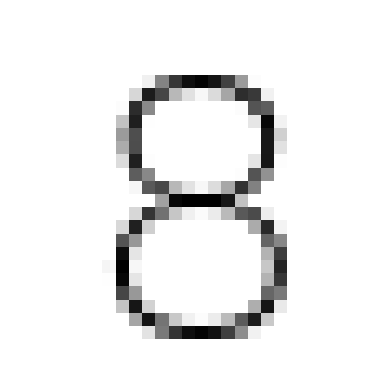

Actual Label: 8, Predicted Label: 8


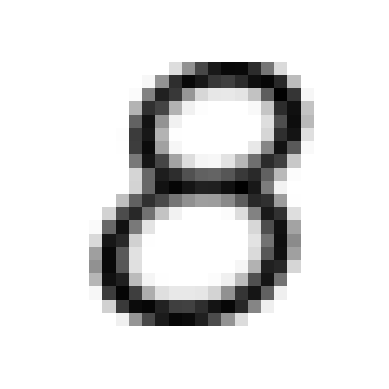

Actual Label: 6, Predicted Label: 6


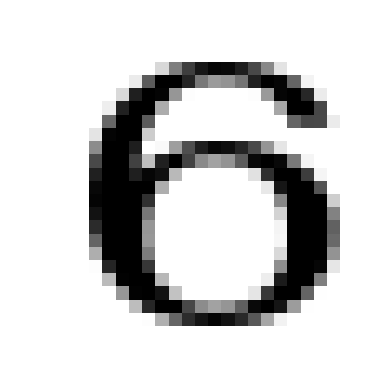

Actual Label: 2, Predicted Label: 2


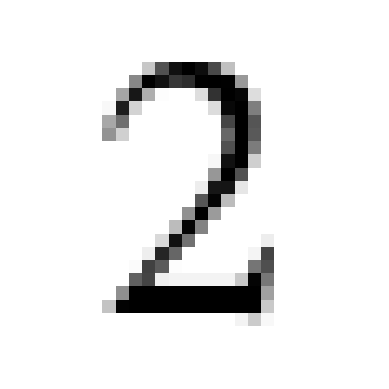

Actual Label: 0, Predicted Label: 0


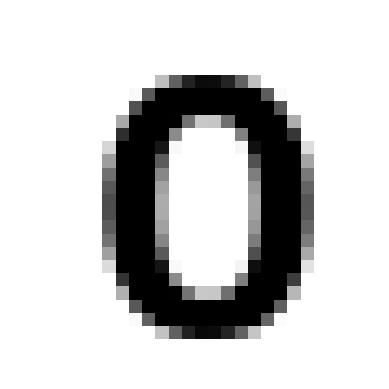

In [27]:
net.eval()   # Set the model to evaluation mode, which disables dropout and batch normalization

num_images = 5   # Number of images to visualize

with torch.no_grad():   # Disable gradient computation for efficiency
    for data in test_loader:   # Loop through the test dataset
        images, labels = data   # Get images and labels from the test dataset
        images = images.to(device)   # Move images to the specified device (e.g., GPU or CPU)
        labels = labels.to(device)   # Move labels to the specified device

        outputs = net(images.float())   # Forward pass to get predicted outputs from the model
        predictions = torch.argmax(outputs, dim=1)   # Get predicted labels with maximum probability

        for i in range(data[0].shape[0]):   # Loop through the images in the current batch
            pred = predictions[i].item()   # Get the predicted label for the current image
            label = labels[i]   # Get the actual label for the current image
            if(num_images > 0):   # Check if the number of images to visualize is greater than 0
                print(f'Actual Label: {pred}, Predicted Label: {label}')   # Print the actual and predicted label for the current image
                img = np.reshape(images[i].cpu().numpy(),[1,28,28])   # Convert the image tensor to a NumPy array and reshape it to [1, 28, 28] size
                visualize_image(img)   # Visualize the image using a custom function (e.g., visualize_image)
                num_images -= 1   # Decrement the number of images to visualize by 1


## **Plotting training logs**

To further understand and analyse the training of our model, let us plot the training logs for loss and accuracy.



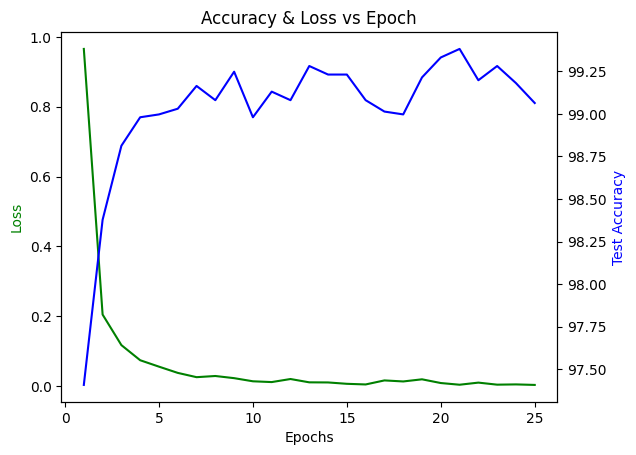

In [28]:
fig, ax1 = plt.subplots()   # Create a figure with a single subplot and return the figure object and axes object

plt.title("Accuracy & Loss vs Epoch")   # Set the title of the plot

ax2 = ax1.twinx()   # Create a twin y-axis on the right side of the plot

ax1.plot(epoch_log, loss_log, 'g-')   # Plot the epoch vs loss with green color
ax2.plot(epoch_log, accuracy_log, 'b-')   # Plot the epoch vs test accuracy with blue color on the twin y-axis

ax1.set_xlabel('Epochs')   # Set the x-axis label to 'Epochs'
ax1.set_ylabel('Loss', color='g')   # Set the left y-axis label to 'Loss' with green color
ax2.set_ylabel('Test Accuracy', color='b')   # Set the right y-axis label to 'Test Accuracy' with blue color

plt.show()   # Display the plot


Observations: As the Number of Epochs increases i.e number of times you run the dataset through model, test accuracy increases and loss decreases

## **Plotting Confusion Matrix**

Lastly, let us plot the confusion matrix to evaluate the classwise performance of our model and understand where it can do better.

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [30]:
pred_list = torch.zeros(0, dtype=torch.long, device='cpu')   # Create an empty tensor to store predicted labels with dtype long and device CPU
label_list = torch.zeros(0, dtype=torch.long, device='cpu')   # Create an empty tensor to store actual labels with dtype long and device CPU

with torch.no_grad():   # Turn off gradient computation during inference
    for i, (inputs, classes) in enumerate(test_loader):   # Iterate over the test data loader
        inputs = inputs.to(device)   # Move inputs to the specified device (e.g., CPU or GPU)
        classes = classes.to(device)   # Move actual labels to the specified device
        outputs = net(inputs.float())   # Pass inputs through the network to get predicted outputs
        _, preds = torch.max(outputs, 1)   # Get the predicted labels by finding the indices of maximum values along the second dimension (class probabilities)

        pred_list = torch.cat([pred_list, preds.view(-1).cpu()])   # Concatenate predicted labels to the pred_list tensor, reshaping to 1D and moving to CPU
        label_list = torch.cat([label_list, classes.view(-1).cpu()])   # Concatenate actual labels to the label_list tensor, reshaping to 1D and moving to CPU

Further, let us visualise this confusion matrix.

In [31]:
conf_mat = confusion_matrix(label_list.numpy(), pred_list.numpy())   # Compute the confusion matrix using predicted and actual labels converted to NumPy arrays
class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)   # Define the class names as a tuple of integers from 0 to 9
dataframe = pd.DataFrame(conf_mat, index=class_names, columns=class_names)   # Create a DataFrame from the confusion matrix, with class names as row and column indices

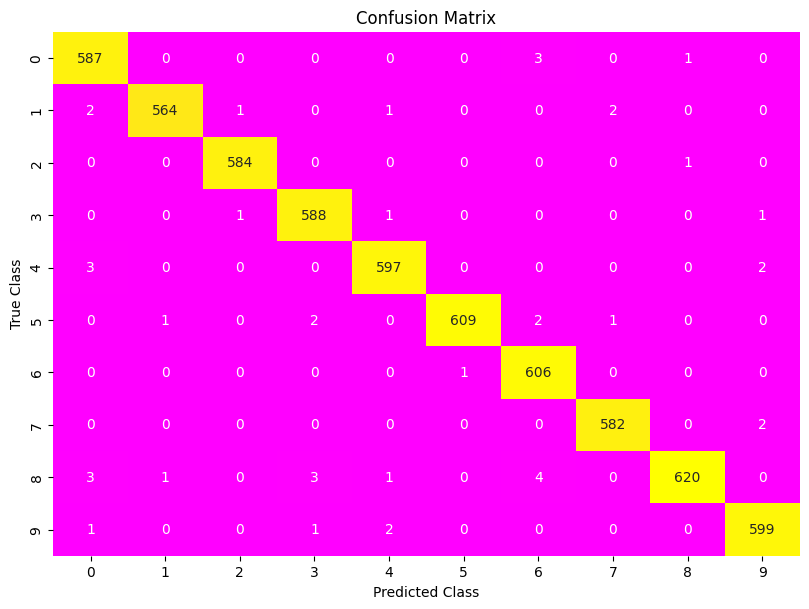

In [35]:
#plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(dataframe, annot=True, cbar=None,cmap="spring",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()

### **Observations:**
He we infer that , 587 times the label was 0 and our model predicted it as 0.Similarly 564 times label was 1 and and model predicted 1. Highest value is 4 , which means four times the label was 8 (True class) and our model predicted it 3, which is considered as error.

## **Conclusion**

- The accuracy on test test is 99.1% which is really good for CNN
CNNs, or Convolutional Neural Networks, are specialized neural networks for processing data with a known grid-like topology, such as images or time-series data.
- CNNs consist of convolutional layers, pooling layers, and fully connected layers, and are commonly used in computer vision and other areas of deep learning.
- Convolutional layers perform convolution on the input data to extract local patterns or features.
- Pooling layers downsample the spatial dimensions of the data while preserving important features.
- Activation functions, such as ReLU, sigmoid, and tanh, introduce non-linearity into the network.
- We have successfully created a CNN model using Pytorch.

## **References**
- https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939
- https://www.researchgate.net/figure/A-Convolutional-neural-network-sequence-to-classify-handwritten-digits_fig5_364953720
- https://www.youtube.com/watch?v=9cPMFTwBdM4&ab_channel=Ductileasy
- https://www.youtube.com/watch?v=YRhxdVk_sIs&ab_channel=deeplizard
- https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel

### **Licensing**

Copyright 2023 Payal Sanjay Nagaonkar

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.